In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from advopt import tasks
from advopt.target.utils import combine

In [2]:
task = tasks.SwissRoll()
assert len(task.search_space()) == 1, 'This example only works for 1D search space.'

params = np.linspace(task.search_space()[0][0], task.search_space()[0][1], num=51)

clf_type = 'NN'
size = 128 * 1024

In [3]:
### to obtain smooth curves we reuse the same data
### the same effect can be achieved by averaging curves over multiple runs.

data_pos = task.ground_truth_generator()(size)
data_pos_test = task.ground_truth_generator()(size)

if task.is_synthetic():
    data_neg_0 = task.ground_truth_generator()(size)
    data_neg_test_0 = task.ground_truth_generator()(size)
else:
    data_neg_0 = None
    data_neg_test_0 = None

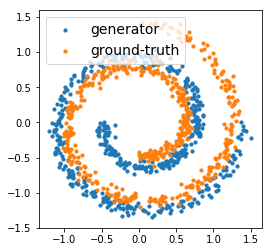

In [4]:
try:
    d_pos = task.ground_truth_generator()(size)
    d_neg = task.generator(task.example_parameters())(size)
    
    plt.figure(figsize=(4, 4))
    plt.scatter(d_neg[:512, 0], d_neg[:512, 1], label='generator', s=10)
    plt.scatter(d_pos[:512, 0], d_pos[:512, 1], label='ground-truth', s=10)
    plt.legend(loc='upper left', fontsize=14)
    plt.savefig('%s-example.pdf' % (task.name(), ))
except:
    pass

In [ ]:
param = np.pi / 4
if task.is_synthetic():
    data_neg = task.transform(data_neg_0, [param])
    data_neg_test = task.transform(data_neg_test_0, [param])
else:
    data_neg = task.generator([param])(size)
    data_neg_test = task.generator([param])(size)

In [ ]:
data, labels = combine(data_pos, data_neg)
data = data.astype('float32')

In [ ]:
import torch

In [ ]:
import torch
from torch import nn

class Network(nn.Module):
  def __init__(self, ndim):
    super(Network, self).__init__()
    
    self.layer1 = nn.Linear(in_features=ndim, out_features=512)
    self.layer2 = nn.Linear(in_features=512, out_features=256)
    self.layer3 = nn.Linear(in_features=256, out_features=1)

    self.activation = nn.Softplus()

  def forward(self, X):
    X1 = self.activation(self.layer1(X))
    X2 = self.activation(self.layer2(X1))
    return torch.squeeze(self.layer3(X2), dim=1)

In [ ]:
net = Network(2).cuda()

In [ ]:
X = torch.tensor(data).cuda()
y = torch.tensor(labels).cuda()

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
for _ in tqdm(range(16 * 1024)):
    opt.zero_grad()
    indx = np.random.randint(0, data.shape[0], dtype='int32', size=(32, ))
    
    X_batch = torch.tensor(data[indx]).cuda()
    y_batch = torch.tensor(labels[indx]).cuda()
    
    pred = net(X_batch)
    loss = loss_fn(pred, y_batch)
    
    loss.backward()
    opt.step()

In [ ]:
def predict_grid(space, steps=20):
    xs = tuple([
      np.linspace(lower_x, upper_x, num=steps)
      for lower_x, upper_x in space
    ])

    grids = np.meshgrid(*xs)
    X = np.vstack([grid.reshape(-1) for grid in grids]).T.astype('float32')
    X_t = torch.tensor(X, requires_grad=False).cuda()

    proba = net(X_t).cpu().detach().numpy()
    proba = proba.reshape((steps, ) * len(space))

    return xs, proba

In [ ]:
(xs, ys), Z = predict_grid([(-1.5, 1.5), (-1.5, 1.5)])

In [ ]:
plt.contourf(xs, ys, Z)